# CREDIT SCORECARD DEVELOPMENT
- In this notebook we will create a credit scorecard and get the probabilities of default (PDs) for each customer.
- Scorecards are important as they help in knowing what type of customers you are dealing with in terms of their level of risk once they are given a loan.
- The PDs help in calculating the Expected Credit Losses (ECL) for a financial institution that lends money.
- We will use a data from a peer to peer lending club to create the model and later use the same data in calculating the Loss Given Default(LGDs) and Exposure at default(EAD) which are also parameters for calculating the ECL.

In [ ]:
# Install pandas profiling
! pip install ydata-profiling


In [ ]:
# Install toad
! pip install toad

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ydata_profiling
from ydata_profiling import ProfileReport
from datetime import datetime
from dateutil.relativedelta import relativedelta
import toad
from sklearn.metrics import RocCurveDisplay,roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving loan_data_2007_2014.csv to loan_data_2007_2014.csv


In [ ]:
# load the data
data=pd.read_csv("/content/loan_data_2007_2014.csv",low_memory=False)
pd.options.display.max_columns = None # does not limit the number of columns
print(data.shape)
data.head()

(466285, 75)


Unnamed: 0       id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
0           0  1077501    1296599       5000         5000           4975.0   
1           1  1077430    1314167       2500         2500           2500.0   
2           2  1077175    1313524       2400         2400           2400.0   
3           3  1076863    1277178      10000        10000          10000.0   
4           4  1075358    1311748       3000         3000           3000.0   

         term  int_rate  installment grade sub_grade  \
0   36 months     10.65       162.87     B        B2   
1   60 months     15.27        59.83     C        C4   
2   36 months     15.96        84.33     C        C5   
3   36 months     13.49       339.31     C        C1   
4   60 months     12.69        67.79     B        B5   

                  emp_title emp_length home_ownership  annual_inc  \
0                       NaN  10+ years           RENT     24000.0   
1                     Ryder   < 1 year           RENT     30000.0   
2                       NaN  10+ years           RENT     12252.0   
3       AIR RESOURCES BOARD  10+ years           RENT     49200.0   
4  University Medical Group     1 year           RENT     80000.0   

  verification_status issue_d  loan_status pymnt_plan  \
0            Verified  Dec-11   Fully Paid          n   
1     Source Verified  Dec-11  Charged Off          n   
2        Not Verified  Dec-11   Fully Paid          n   
3     Source Verified  Dec-11   Fully Paid          n   
4     Source Verified  Dec-11      Current          n   

                                                 url  \
0  https://www.lendingclub.com/browse/loanDetail....   
1  https://www.lendingclub.com/browse/loanDetail....   
2  https://www.lendingclub.com/browse/loanDetail....   
3  https://www.lendingclub.com/browse/loanDetail....   
4  https://www.lendingclub.com/browse/loanDetail....   

                                                desc         purpose  \
0    Borrower added on 12/22/11 > I need to upgra...     credit_card   
1    Borrower added on 12/22/11 > I plan to use t...             car   
2                                                NaN  small_business   
3    Borrower added on 12/21/11 > to pay for prop...           other   
4    Borrower added on 12/21/11 > I plan on combi...           other   

                  title zip_code addr_state    dti  delinq_2yrs  \
0              Computer    860xx         AZ  27.65          0.0   
1                  bike    309xx         GA   1.00          0.0   
2  real estate business    606xx         IL   8.72          0.0   
3              personel    917xx         CA  20.00          0.0   
4              Personal    972xx         OR  17.94          0.0   

  earliest_cr_line  inq_last_6mths  mths_since_last_delinq  \
0           Jan-85             1.0                     NaN   
1           Apr-99             5.0                     NaN   
2           Nov-01             2.0                     NaN   
3           Feb-96             1.0                    35.0   
4           Jan-96             0.0                    38.0   

   mths_since_last_record  open_acc  pub_rec  revol_bal  revol_util  \
0                     NaN       3.0      0.0      13648        83.7   
1                     NaN       3.0      0.0       1687         9.4   
2                     NaN       2.0      0.0       2956        98.5   
3                     NaN      10.0      0.0       5598        21.0   
4                     NaN      15.0      0.0      27783        53.9   

   total_acc initial_list_status  out_prncp  out_prncp_inv   total_pymnt  \
0        9.0                   f        0.0            0.0   5861.071414   
1        4.0                   f        0.0            0.0   1008.710000   
2       10.0                   f        0.0            0.0   3003.653644   
3       37.0                   f        0.0            0.0  12226.302210   
4       38.0                   f      766.9          766.9   3242.170000   

   total_

In [ ]:
profile = ProfileReport(data, minimal=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Metrics to consider when creating a scorecard


1.   Payment Capability of the borrower.
    

*   Employment Stability - we will use the length of employment
*   Assets- we measure the assets owned by the loan borrower by checking the home ownership status
-   Income - annual income and verification status
*   Debt-to-income - this is the ratio of the total debts that the borrower have compared to what they are earning. The ideal ratio is 36% but a maximum of 43% is considered.


2.   Credit History


*   Credit history tenure - we will take the difference the "issue_date" and "earliest_cr_line"
*   Records of delinquincies and bankruptcy - "mths_since_last_delinq"
*   Outstanding debts
*   Credit utilization

3.  Loan Characteristic


*   Loan amount, interest rate, installment
*   Purpose
*   Term








# DATA PRE-PROCESSING
- We have a wrangle function that cleans the data by:

1) Dropping the following features:


*   Redundant columns - high cardinality and one unique value.
*   Columns that are subsets of other columns eg "grade" and "subgrade".
* "loan_amnt", "funded_amnt" and "funded_amnt_inv" have a perfect correlation. "installment" has almost a perfect correlation with the 3 variables. we will use "loan amnt".
* "desc", "title" and "purpose" are all describing the use of the loan so we drop "desc" and "title" since they have higher cardinality compared to "purpose".
- The following represent part of the funded amount that has been paid."total_pymnt","total_pymnt_inv" and "total_rec_prncp"
-"out_prncp" and "out_prncp_inv" have a perfect correlation, we drop "out_prncp_inv".
- "recoveries" and "collection_recovery_fee" are also highly correlated, we drop the latter.
* Drop any feature that has 80% missing data.

2) Converting into right formats, slicing and filling missing data.
* Convert employment length into a numerical feature and fill all the missing rows with 0.
* Slice the data under the annual income into 10th and 90th percentile inoredr to remove the outliers.
* Convert the term feature from string into numerical.
* Fill all the missing rows with -999.

3) We will create a loan to income ratio feature since calculation of dti excludes mortgage and the requested LC loan when computing it.


In [ ]:
def wrangle(df):
  # redundant columns
  # payment plan no=99% and y=1% so we drop it
  df.drop(columns=["Unnamed: 0","id","member_id","url","emp_title","pymnt_plan","zip_code","policy_code","application_type","addr_state",'last_pymnt_d'],inplace=True)

  # Columns that are subsets of others
  df.drop(columns=["grade","installment"],inplace=True)

  # Columns giving the same information/multicollinearity
  df.drop(columns=["desc","title","out_prncp_inv","total_pymnt_inv","total_pymnt","total_rec_prncp","funded_amnt","funded_amnt_inv","collection_recovery_fee",
                    "total_rev_hi_lim","total_rec_int","open_acc"],inplace=True)

  # Drop correlated variables
  df.drop(columns=["pub_rec","acc_now_delinq","delinq_2yrs"],inplace=True)

  # Columns with 70% missing values
  df.dropna(axis=1,thresh=0.8*len(df),inplace=True)

  # Convert the feature emp_length into float from string
  df["emp_length"]=df["emp_length"].replace({"10+ years":"10 years","< 1 year":"0 years"}).str[:2].astype("float")
  # Fill missing value of emp_length with 0
  df["emp_length"].fillna(0,inplace=True)

  # Combine other,none and any into one category "other"
  df.loc[(df["home_ownership"]=="NONE")|(df["home_ownership"]=="ANY"),"home_ownership"]="OTHER"

  # Remove outliers on the annual income column by slicing the data into 10th and 90th percentiles
  low,high=df["annual_inc"].quantile([0.05,0.95])
  mask=df["annual_inc"].between(low,high)
  df=df[mask]

  # Convert the term column from string to integer
  df["term"]=df["term"].str.replace(" ","").str[:2].astype(int)

  # create a new feature loan to income ratio
  df["loan_to_income_ratio"]=df["loan_amnt"]/df["annual_inc"]

   # Replace all numerical features where there is null value with -999
  df[df.select_dtypes(include=['int64', 'float64']).columns] = df.select_dtypes(include=['int64', 'float64']).fillna(-999)


  return df

data=wrangle(data)

Text(0.5, 1.0, 'Pearson correlation')

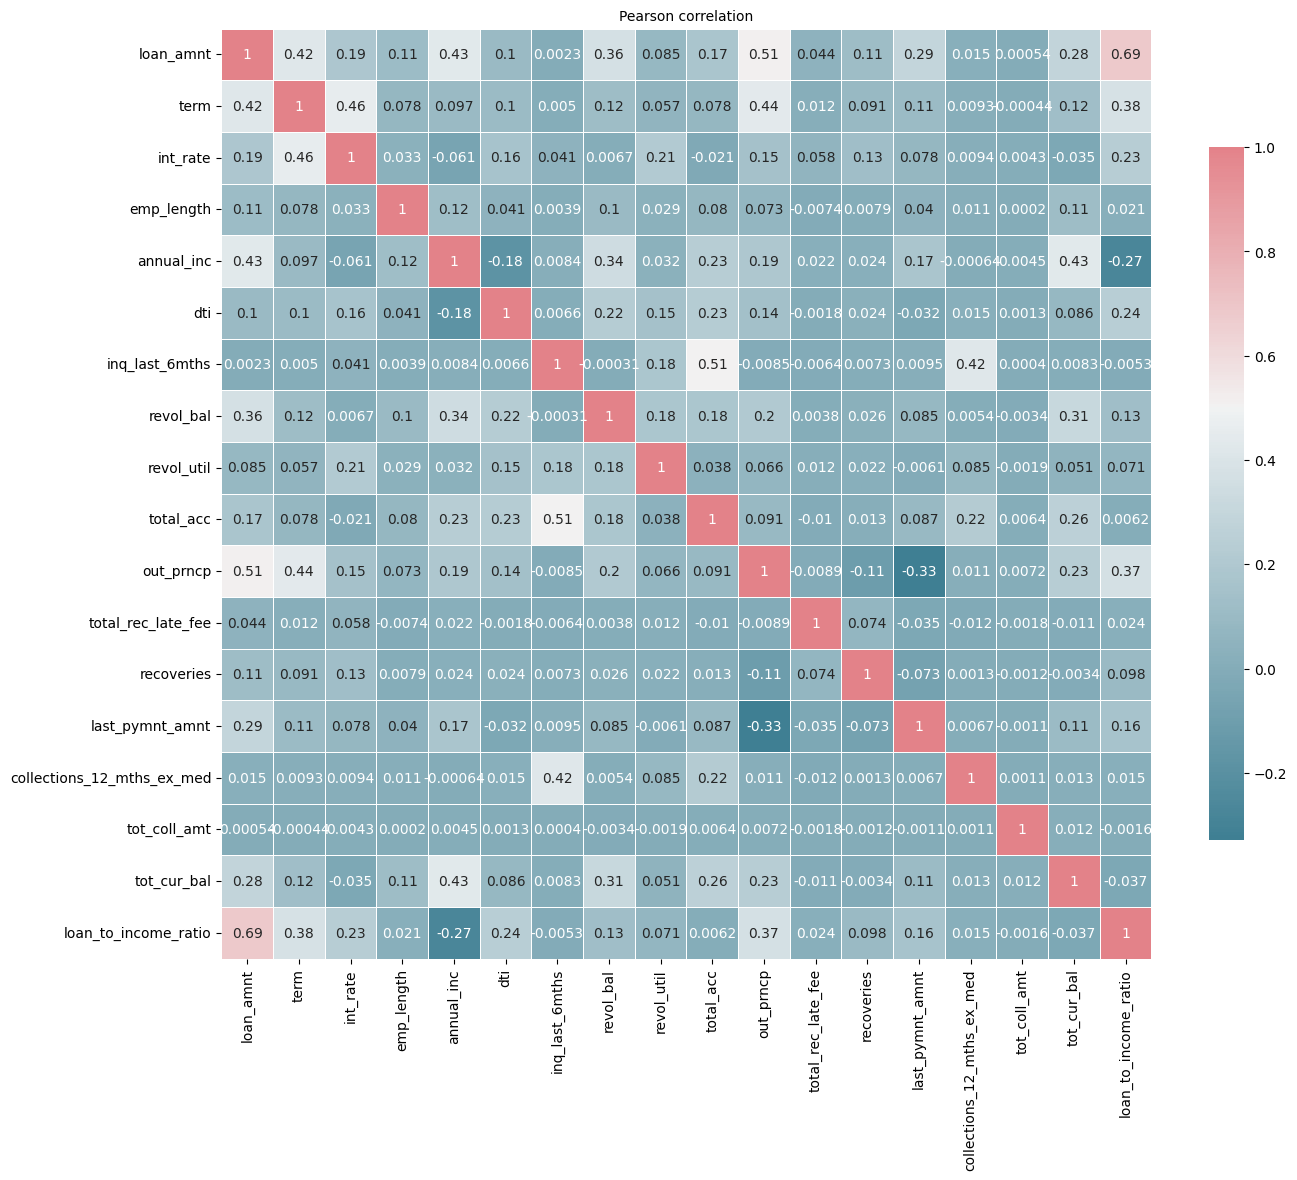

In [ ]:
numeric_features=data.select_dtypes(include="number")
correlation=numeric_features.corr()
#mask = np.triu(np.ones_like(corrmat, dtype=np.bool))
f, ax = plt.subplots(figsize=(15,15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(correlation, cmap= cmap, vmax=1, center=0.5,
            square=True, linewidths=.5, cbar_kws={"shrink": .6},annot=True)

plt.title("Pearson correlation", fontsize =10)

In [ ]:
pd.options.display.max_rows = None # does not limit the number of rows
data.isnull().sum()

loan_amnt                      0
term                           0
int_rate                       0
sub_grade                      0
emp_length                     0
home_ownership                 0
annual_inc                     0
verification_status            0
issue_d                        0
loan_status                    0
purpose                        0
dti                            0
earliest_cr_line              17
inq_last_6mths                 0
revol_bal                      0
revol_util                     0
total_acc                      0
initial_list_status            0
out_prncp                      0
total_rec_late_fee             0
recoveries                     0
last_pymnt_amnt                0
last_credit_pull_d            39
collections_12_mths_ex_med     0
tot_coll_amt                   0
tot_cur_bal                    0
loan_to_income_ratio           0
dtype: int64

# Credit History
## 1) Credit history tenure - change the "earliest_cr_line" and "issue_d" into date time.

In [ ]:
# convert into date time
data["issue_d"]=pd.to_datetime(data["issue_d"],format='%b-%y')
data["earliest_cr_line"]=pd.to_datetime(data["earliest_cr_line"],format='%b-%y')
data["last_credit_pull_d"]=pd.to_datetime(data["last_credit_pull_d"],format='%b-%y')

# Create a column "cred_hist_tenure" for credit history length
data["cred_hist_tenure"]= round((data["issue_d"] - data["earliest_cr_line"]).dt.days/365,2)

# We drop the "earliest_cr_line" column
data.drop(columns=["earliest_cr_line"],inplace=True)


# Target Variable
- The target variable will be "loan_status".
- An account is said to be defaulted if it is 90 DPD (90 days past due).
- The column "loan_status" has 9 different levels, we will group them into 2 categories:
     * Non-defaulted loans (equal to 0):
                  - Current
                  - Fully Paid
                  - In Grace Period
                  - Late (16-30 days)
                  - Does not meet the credit policy. Status:Fully Paid
    * Defaulted loans (equal to 1):
                  - Charged-off
                  - Late (31-120 days)
                  - Default
                  - Does not meet the credit policy. Status:Charged Off



In [ ]:
default=["Charged Off","Late (31-120 days)","Default","Does not meet the credit policy. Status:Charged Off"]
data["loan_status"]=data["loan_status"].isin(default).astype(int) # assign defaulted=1 and non-defaulted=0

In [ ]:
# checking the proportion of the 2 categories 0=non-defaulted accounts and 1=defaulted accounts
data["loan_status"].value_counts(normalize=True)

loan_status
0    0.891204
1    0.108796
Name: proportion, dtype: float64

# Split the data into training and testing set
- We will use the issue date extract the year and use it for splitting.
- Training set - 2007 upto 2013
- Testing set -  2014

In [ ]:
# Extract the year from the issue date
data["year"]=data["issue_d"].dt.year

# Drop the column"issue_d"
data.drop(columns=["issue_d"],inplace=True)

# Split train and test
train=data.loc[data['year'].isin([2007,208,2009,2010,2011,2012,2013])==True,:]
test=data.loc[data['year'].isin([2007,208,2009,2010,2011,2012,2013])==False,:]


# Feature Selection
- Select the features by dropping columns that have:
   - 60% missing values.
   - Less than 0.02 information value.
   - pearson's correlatuion coefficient >= 0.9.

In [ ]:
train_selected,dropped_features=toad.selection.select(train,target=train["loan_status"],empty=0.6,iv=0.02,corr=0.9,return_drop=True)
print(train_selected.shape[1])
print(dropped_features)

17
{'empty': array([], dtype=float64), 'iv': array(['emp_length', 'home_ownership', 'verification_status', 'revol_bal',
       'total_acc', 'initial_list_status', 'collections_12_mths_ex_med',
       'tot_coll_amt', 'cred_hist_tenure', 'year'], dtype=object), 'corr': array([], dtype=object)}


In [ ]:
train_selected.columns

Index(['loan_amnt', 'term', 'int_rate', 'sub_grade', 'annual_inc',
       'loan_status', 'purpose', 'dti', 'inq_last_6mths', 'revol_util',
       'out_prncp', 'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt',
       'last_credit_pull_d', 'tot_cur_bal', 'loan_to_income_ratio'],
      dtype='object')

# Feature Binning
- This is converting the numerical variables into categorical variables.
- Always remember to exclude timestamp columns when binning.
- The process of feature binning is as follows:


1.   Initialize
2.   Train binning: c.fit(dataframe,y="target", method="chi", min_samples=None, n_bins=None,empty_separate=False)
        * y - target variable;
        * method - this is the method of binning can take options such as:'chi' (Chi-squared), 'dt', (decisin tree), 'kmeans' (K-means), 'quantile' (by the same percentile), and 'step' (by the same step);
        * min_samples - this is the minimum sample of data that a bin can hold;
        * n_bins - minimum number of bins;
        * empty_separate - whether to put missing values in a separate bin, if false the missing values are put in the buckets with most bad rates.




In [ ]:
# Instantiate the combiner
c=toad.transform.Combiner()

# train the binning
c.fit(train_selected,y="loan_status",method="chi",min_samples=0.05,n_bins=None,empty_separate=False,exclude=["last_credit_pull_d"])

# Check the binning results
#c.export()

# Apply binning to the whole data
train_bins=c.transform(train_selected)
test_bins=c.transform(test[train_selected.columns])

In [ ]:
c.export()

{'loan_amnt': [7025, 11900, 15250, 24025],
 'term': [60],
 'int_rate': [7.9, 9.76, 12.12, 13.99, 14.54, 16.29, 17.77, 20.89],
 'sub_grade': [['A1', 'A2', 'A3', 'A4', 'A5'],
  ['B1', 'B2'],
  ['B3', 'B4'],
  ['B5', 'C1', 'C2'],
  ['C3', 'C4', 'C5'],
  ['D1', 'D2', 'D3', 'D5', 'D4', 'E1'],
  ['G4',
   'E3',
   'E2',
   'E4',
   'F1',
   'E5',
   'F2',
   'G2',
   'F3',
   'F4',
   'G5',
   'G1',
   'F5',
   'G3']],
 'annual_inc': [36672.0, 49227.0, 54173.0, 65253.0, 80005.0, 98280.0],
 'purpose': [['car',
   'major_purchase',
   'credit_card',
   'home_improvement',
   'wedding'],
  ['debt_consolidation', 'vacation', 'house'],
  ['medical',
   'other',
   'moving',
   'educational',
   'renewable_energy',
   'small_business']],
 'dti': [7.82, 10.92, 16.03, 18.27, 20.78, 29.02],
 'inq_last_6mths': [1.0, 2.0, 3.0],
 'revol_util': [23.0, 47.1, 57.4, 67.1, 84.1],
 'out_prncp': [0.01, 2839.28],
 'total_rec_late_fee': [],
 'recoveries': [4.4],
 'last_pymnt_amnt': [1367.68],
 'tot_cur_bal': [0.

In [ ]:
train_bins.head()

loan_amnt  term  int_rate  sub_grade  annual_inc    issue_d  loan_status  \
1          0     1         5          4           0 2011-12-01            1   
3          1     0         3          3           1 2011-12-01            0   
4          0     1         3          3           4 2011-12-01            0   
5          0     0         1          0           0 2011-12-01            0   
6          0     1         5          4           1 2011-12-01            0   

   purpose  dti  inq_last_6mths  revol_util  out_prncp  total_rec_late_fee  \
1        0    0               3           0          0                   0   
3        2    4               1           0          0                   0   
4        2    3               0           2          1                   0   
5        0    2               3           1          0                   0   
6        1    5               1           5          1                   0   

   recoveries  last_pymnt_amnt last_credit_pull_d  tot_cur_bal  \
1           1                0             Sep-13            0   
3           0                0             Jan-15            0   
4           0                0             Jan-16            0   
5           0                0             Sep-15            0   
6           0                0             Jan-16            0   

   loan_to_income_ratio  
1                     0  
3                     1  
4                     0  
5                     0  
6                     0

# Monotonicity
- We need to make sure that the binning has monotonicity by ensuring that the red line moves in one direction and there are no sudden jumps or drops.
- The bar plot represents the proportion of data used in each bin while the red line represents the propotion of defaults.

In [ ]:
from toad.plot import bin_plot
for col in train_selected.columns:
  if col !=["loan_status","last_pymnt_d","last_credit_pull_d"]:
    toad.plot.bin_plot(c.transform(train_selected[[col,"loan_status"]], labels=True), x=col, target='loan_status')


# WOE Transformation
- WOE - is used to measure the strength of each attribute in separating the goods and bad risks.
- A negative WOE indicates that the proportion of bad is more than the proportion of good in a certain bin. A positive WOE indicates that the proportion of goods is more than the bads in a bin.
- The calculation is as follows:
$$WOE=\Biggl[In \Biggl(\frac{\text{Distribution of good credit outcome}}{\text{Distribution of bad credit outcome}}\Biggr)\Biggr] * 100\\
= \Biggl[In \Biggl(\text{Odds ratio}\Biggr)\Biggr] * 100$$
- The transformation happens to even the data that was not binned during binning.
- Always remember to $\textbf{exclude}$ the $\textbf{target variable}$

In [ ]:
# Initialize the transer
t=toad.transform.WOETransformer()

# Fit and transform
train_woe=t.fit_transform(train_bins,train["loan_status"],exclude=["last_credit_pull_d","loan_status"])
test_woe=t.transform(test_bins)


In [ ]:
train_woe.head()

loan_amnt      term  int_rate  sub_grade  annual_inc  loan_status  \
1  -0.161302  0.431168  0.138526   0.200884    0.284126            1   
3  -0.036043 -0.179479 -0.154674  -0.023596    0.196243            0   
4  -0.161302  0.431168 -0.154674  -0.023596   -0.092690            0   
5  -0.161302 -0.179479 -0.819868  -1.047386    0.284126            0   
6  -0.161302  0.431168  0.138526   0.200884    0.196243            0   

    purpose       dti  inq_last_6mths  revol_util  out_prncp  \
1 -0.232066 -0.307879        0.408467   -0.436933   0.342756   
3  0.365306  0.089079        0.065831   -0.436933   0.342756   
4  0.365306 -0.000453       -0.196729   -0.051343  -1.926899   
5 -0.232066 -0.094746        0.408467   -0.159158   0.342756   
6  0.050064  0.192021        0.065831    0.275512  -1.926899   

   total_rec_late_fee  recoveries  last_pymnt_amnt last_credit_pull_d  \
1                 0.0   11.595145         0.569699             Sep-13   
3                 0.0   -0.929874         0.569699             Jan-15   
4                 0.0   -0.929874         0.569699             Jan-16   
5                 0.0   -0.929874         0.569699             Sep-15   
6                 0.0   -0.929874         0.569699             Jan-16   

   tot_cur_bal  loan_to_income_ratio  
1     0.136282             -0.271898  
3     0.136282             -0.104632  
4     0.136282             -0.271898  
5     0.136282             -0.271898  
6     0.136282             -0.271898

In [ ]:
train_woe.columns.to_list()

['loan_amnt',
 'term',
 'int_rate',
 'sub_grade',
 'annual_inc',
 'loan_status',
 'purpose',
 'dti',
 'inq_last_6mths',
 'revol_util',
 'out_prncp',
 'total_rec_late_fee',
 'recoveries',
 'last_pymnt_amnt',
 'last_credit_pull_d',
 'tot_cur_bal',
 'loan_to_income_ratio']

# Step-wise Regression for feature selection
- Stepwise regression involves adding or removing explanatory variable during model creation and evalating the statistical significance of the variables.
- Types of stepwise regression:
     - Forward selection involves starting with no variable and then adds a variable at a time evaluating its statistical significance.
     - Backward selection, we start with the variables and then start removing one at a time and we evaluate the statistical significance of its removal.
     - Both direction involves both the forward and backward selection. $\textbf{This produces the best results.}$
- We use step-wise feature selection as follows:
toad.selection.stepwise (dataframe, target='target', estimator='ols', direction='both', criterion='aic', max_iter=None, return_drop=False, exclude=None)
   * target - target variable;
   * estimator - the regression model to fit, support 'ols', 'lr', 'lasso', 'ridge';
   * direction - stepwise direction, support 'forward', 'backward', 'both';
   * criterion - selection criteria, support 'aic', 'bic', 'ks', 'auc';
   * max_iter - maximum number of iterations;
   * return_drop - whether to return a list of dropped column names
- Setting $\textbf{estimator="ols" and criterion="aic" makes the stepwise to be fast.}$

In [ ]:
final_train,dropped_cols=toad.selection.stepwise(train_woe,target="loan_status",estimator="ols",direction="both",criterion="aic",return_drop=True,exclude=["last_credit_pull_d"])
final_test=test_woe[final_train.columns]

In [ ]:
dropped_cols

['tot_cur_bal', 'term', 'sub_grade', 'purpose', 'total_rec_late_fee']

In [ ]:
final_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 207316 entries, 1 to 230656
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             207316 non-null  float64
 1   int_rate              207316 non-null  float64
 2   annual_inc            207316 non-null  float64
 3   loan_status           207316 non-null  int64  
 4   dti                   207316 non-null  float64
 5   inq_last_6mths        207316 non-null  float64
 6   revol_util            207316 non-null  float64
 7   out_prncp             207316 non-null  float64
 8   recoveries            207316 non-null  float64
 9   last_pymnt_amnt       207316 non-null  float64
 10  last_credit_pull_d    207302 non-null  object 
 11  loan_to_income_ratio  207316 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 20.6+ MB


In [ ]:
# Check the information value of each variable
iv_quality=toad.quality(final_train,target="loan_status",iv_only=True)
iv_quality.reset_index(inplace=True)
iv_quality.rename(columns={"index":"variable"},inplace=True)
iv_quality

variable        iv  gini  entropy  unique
0             recoveries  7.582541   NaN      NaN     2.0
1        last_pymnt_amnt  1.792059   NaN      NaN     2.0
2              out_prncp  0.520201   NaN      NaN     3.0
3     last_credit_pull_d  0.325279   NaN      NaN    99.0
4               int_rate  0.296091   NaN      NaN     9.0
5   loan_to_income_ratio  0.074488   NaN      NaN     4.0
6             annual_inc  0.043737   NaN      NaN     7.0
7         inq_last_6mths  0.043391   NaN      NaN     4.0
8             revol_util  0.038558   NaN      NaN     6.0
9                    dti  0.034269   NaN      NaN     7.0
10             loan_amnt  0.017399   NaN      NaN     5.0

<Axes: >

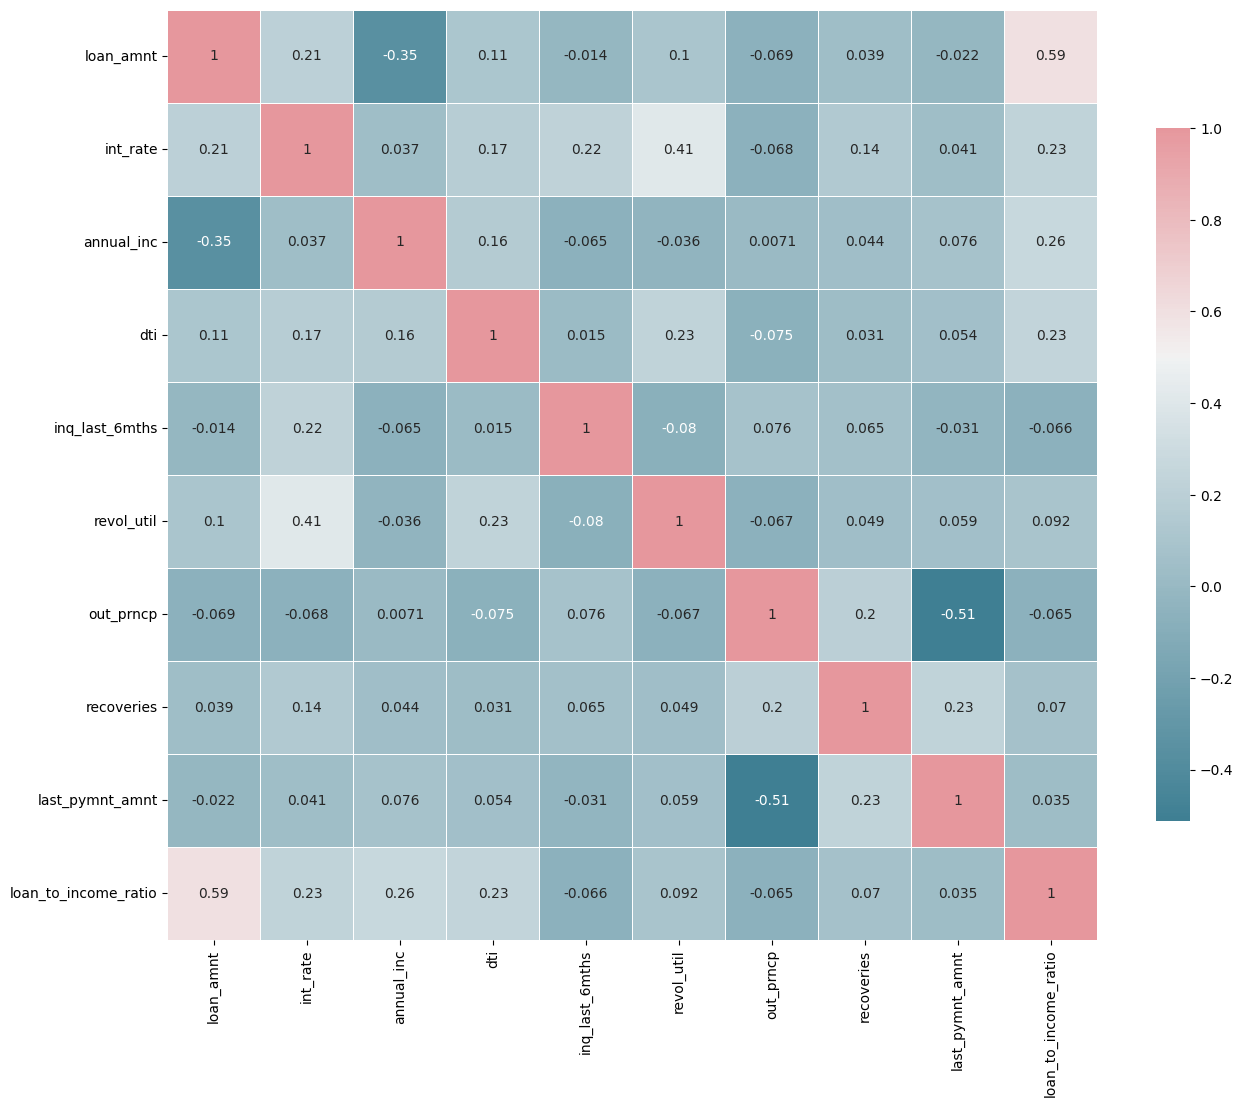

In [ ]:
# We check whether we have variables that are correlated with each other/ multicollinearity
numeric_feat=final_train.select_dtypes(include="number")
numeric_feat=numeric_feat.drop(columns=["loan_status"])
f, ax = plt.subplots(figsize=(15,15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(numeric_feat.corr(),cmap= cmap, vmax=1, center=0.5,
            square=True, linewidths=.5, cbar_kws={"shrink": .6},annot=True)

# Variance Inflation Factor (VIF)
- VIF is used to check the multicollinearity between 2 independent variables in a regression.
- The higher the VIF the higher the chance of multicollinearity existing. If VIF=1 then it means that there is no multicollinearity. If VIF>10 it indicates high multicollinearity.

In [ ]:
final_test.columns

Index(['loan_amnt', 'term', 'int_rate', 'sub_grade', 'annual_inc',
       'loan_status', 'purpose', 'dti', 'inq_last_6mths', 'revol_util',
       'out_prncp', 'recoveries', 'last_pymnt_amnt', 'last_credit_pull_d',
       'tot_cur_bal', 'loan_to_income_ratio'],
      dtype='object')

In [ ]:
# Add a constant term to the independent variables
X=sm.add_constant(numeric_feat)

# VIF for each variable
vif=pd.DataFrame()
vif["variable"]=X.columns
vif["VIF"]=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])] # use a list comprehension

print(vif)

                variable       VIF
0                  const  1.902096
1              loan_amnt  2.778340
2               int_rate  1.424155
3             annual_inc  1.952428
4                    dti  1.133845
5         inq_last_6mths  1.121249
6             revol_util  1.309287
7              out_prncp  1.623294
8             recoveries  1.266154
9        last_pymnt_amnt  1.623212
10  loan_to_income_ratio  2.622171


In [ ]:
# Merge the two dataframes: for IV and VIF
vif_iv_quality=pd.merge(iv_quality,vif,on="variable")
vif_iv_quality.sort_values(by="iv",ascending=False)
vif_iv_quality[["variable","iv","VIF"]]

variable        iv       VIF
0            recoveries  7.582541  1.266154
1       last_pymnt_amnt  1.792059  1.623212
2             out_prncp  0.520201  1.623294
3              int_rate  0.296091  1.424155
4  loan_to_income_ratio  0.074488  2.622171
5            annual_inc  0.043737  1.952428
6        inq_last_6mths  0.043391  1.121249
7            revol_util  0.038558  1.309287
8                   dti  0.034269  1.133845
9             loan_amnt  0.017399  2.778340

In [ ]:
# Drop features that have a VIF>10 or IV>0.5 or IV<0.02
selected_variables=vif_iv_quality[(vif_iv_quality["VIF"]>10) | (vif_iv_quality["iv"]>2) | (vif_iv_quality["iv"]<0.02)]
drop_variables=list(selected_variables["variable"])
drop_variables


['recoveries', 'loan_amnt']

In [ ]:
final_train.columns

Index(['loan_amnt', 'int_rate', 'annual_inc', 'loan_status', 'dti',
       'inq_last_6mths', 'revol_util', 'out_prncp', 'recoveries',
       'last_pymnt_amnt', 'last_credit_pull_d', 'loan_to_income_ratio'],
      dtype='object')

In [ ]:
# Reassign the train and test set
final_train.drop(columns=drop_variables+["last_credit_pull_d"],inplace=True)
final_test.drop(columns=drop_variables+["last_credit_pull_d"],inplace=True)

# Model Development
- We will use Logistic Regression as it is one of the best classifier for scorecard development and what makes it a good classifier is ease in interpreting the results and model explainability.
- We get the probabilities of default (PD) as we will need it in the calculation of Expected Credit Loss (ECL).
- We will use Synthetic Minority Oversampling Technique (SMOTE) for resampling the data as we have an imbalanced dataset.
- We will need to do hyper-parameter tuning to get the best parameters for the model.

In [ ]:
# Split the data into X and y for both the train and the test
X_train=final_train.drop(columns=["loan_status"])
y_train=final_train["loan_status"]
X_test=final_test.drop(columns=["loan_status"])
y_test=final_test["loan_status"]

In [ ]:
# resample the data using SMOTE
from imblearn.over_sampling import SMOTE
sm=SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

## 1) Hyper Parameter Tuning
- This is an optimimzation technique to get the best parameters for the model specific for the data at hand.
- The main hyper paarmeters to tune in logistic regression are:

1.   Solver - this is the algorithm to use in optimization. The choices are {‘newton-cg’, 'lbfgs', ‘liblinear’, ‘sag’, ‘saga’}, default='lbfgs'.
2.   Penalty - this is the regularization and regulates overfitting. The choices are: {'l1', 'l2', 'elasticnet', 'none'}, default='l2'.
3.  Regularization strength (C)  


- We have two  main methods:


1.   Grid Search - this takes values of different hyper parameter and tunes them each at a time until the right combination that gives the best results is achieved. This is done as per the following steps:
   * Parameter grid - which is a dictionary with the keys been the hyper parameters that needs to be tuned and the values is a list of the values to be used for that hyper parameter
   * Instantiate the predictor to be used.
   * We then instantiate the gridsearch class.
2.   Random Search - this randomly chooses the hyper paarameters from the defined set and chooses the best.

- We will use GridSearch method  



In [ ]:
# Define a parameter grid
param_grid=[
 {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'sag'], 'max_iter': [100, 200, 300]},
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1'], 'solver': ['liblinear'], 'max_iter': [100, 200, 300]},
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2', 'elasticnet'], 'solver': ['saga'], 'max_iter': [100, 200, 300]}
]

# Instantiate the predictor
lr=LogisticRegression(max_iter=1000)

# Instantiate GridSearchCV
lr_gridsearch = GridSearchCV(lr, param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=2)

# Perform the grid search using the training data
lr_gridsearch.fit(X_train,y_train)

# Output the best hyperparameters
print("The best hyper parameters are:", lr_gridsearch.best_params_)

# Output the best model score
print("The best recall is:" , lr_gridsearch.score(X_train,y_train))

Fitting 5 folds for each of 105 candidates, totalling 525 fits
The best hyper parameters are: {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
The best recall is: 0.8978175045724227


In [ ]:
X_train["pds"]=pd.Series(predict_xtrain)
X_test["pds"]=pd.Series(predict_xtest)

In [ ]:
X_test.head()

int_rate  annual_inc       dti  inq_last_6mths  revol_util  out_prncp  \
37968 -0.819868    0.196243 -0.307879        0.065831   -0.436933   0.342756   
37969 -0.452419    0.079045 -0.307879        0.408467   -0.436933   0.342756   
37972 -0.154674    0.196243  0.192021        0.232219   -0.436933   0.342756   
37974 -0.819868    0.079045 -0.205952        0.065831   -0.436933   0.342756   
37976 -0.154674   -0.092690 -0.094746       -0.196729    0.125817   0.342756   

       last_pymnt_amnt  loan_to_income_ratio       pds  
37968         0.569699             -0.271898  0.257775  
37969         0.569699             -0.271898  0.062527  
37972         0.569699             -0.271898  0.215035  
37974         0.569699             -0.271898  0.309310  
37976        -3.606579             -0.104632  0.209019

In [ ]:
from toad.metrics import KS, AUC
# Instantiate the predictor
lr=LogisticRegression(random_state=42,C=0.01,max_iter=100,penalty="l1",solver="saga")

# Train the model
model=lr.fit(X_train,y_train)

# Predict the probabilities using the train set
predict_xtrain=lr.predict_proba(X_train)[:,1]

# Predict using the test data
predict_xtest=lr.predict_proba(X_test)[:,1]

# Evaluate using KS for both the Train data and the test data
print("Train KS:", KS(predict_xtrain,y_train))
print("Test KS:", KS(predict_xtest,y_test))

# Evaluate using AUC for both the Train data and the test data (OOT data)
print("Train AUC:",AUC(predict_xtrain,y_train))
print("Test AUC:" ,AUC(predict_xtest,y_test))

# Plot the AUC
fig, ax = plt.subplots(figsize=(12, 8))
RocCurveDisplay.from_estimator(lr, X_test, y_test, color='blue', ax=ax);

Train KS: 0.7093221662131418
Test KS: 0.6919530338726956
Train AUC: 0.9176772420280583
Test AUC: 0.9108953047296503


# Model discriminatory power
* This helps in answering the question: Did we create the model right?
* We need to make sure that the model is able to separate the defaulters and non-defaulters well.
* ROC Curve and Gini Index are used to check this.
* Gini Index= 2 * AUC - 1
* ROc Curve is a plot True positive rate (TPR) against False positive rate (FPR).
$$\text{TPR (Recall / Sensitivity)}=\frac{\text{True positives}}{\text{True positive + False negative}}$$
\
$$\text{FPR}=\frac{\text{False positives}}{\text{False positive + True negative}}$$

In [ ]:
auc=AUC(predict_xtrain,y_train)
gini= 2 * auc - 1
gini

0.8353544840561167

array([0.22860177, 0.17117362, 0.1153827 , ..., 0.1449762 , 0.21068884,
       0.17648982])

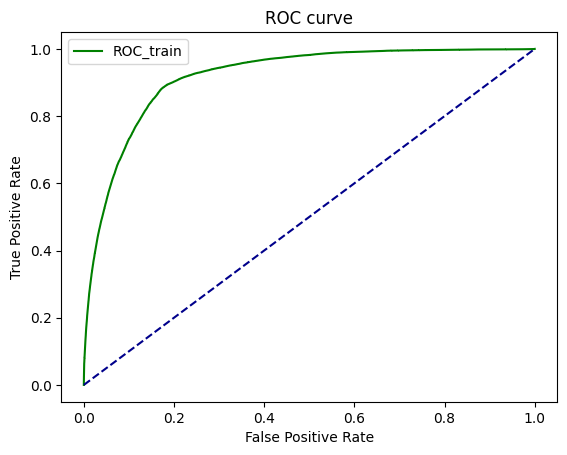

In [ ]:
# Plot the ROC curve
fpr,tpr,threshold=roc_curve(y_train,predict_xtrain)
plt.plot(fpr, tpr, color='green', label='ROC_train')
#fper,tper,threshold=roc_curve(final_ytest,final_xtest.logit)
#plt.plot(fper, tper, color='orange', label='ROC_test')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend();

# Scorecard Development
- We need to score customer according to their risk level.
- The credit score is calculated as follows:
$$\text{Score = offset + factor * In(odds)}$$
- The parameters used are:
    * Score - this is the value that a creditor is assigned to compared to their level of risk.
    * Offset - this is a constant value added to the score inorder to meet the business objective.
    * Factor - this is multiplied by the logistic regression coefficients to convert them into points. It is calculated as follows:
    $$\text{factor}=\frac{\text{pdo}}{log(2)}$$
    * Odds - this is the likelihood of a customer paying back the loan  in full compared to them defaulting for example 30:1 means that out of 30 customers 1 will default on their loan. It is calculated as follows  $$\text{odds}=\frac{1-\text{logit}}{\text{logit}}$$
# Combining logistic regression and WOE in scorecard development
- When we incorporate logistic regression and WOE the score is calculated as follows:$$\text{score}_{i} = \Biggl( \beta_{i} * \text{WOE}_{i} + \frac{\alpha}{n} \Biggr) * \text{factor} + \frac{\text{offset}}{n}$$
  * $\beta_{i}$ - this is the coefficient of variable i.
  * $\alpha$ - this is the intercept.
  * n - this is the number of bins in feature i.

# Toad package for scorecard development
- We will use toad to create the scorecard.
- Base_odds=36, base_score=660, pdo=40, rate=2 ----means a base odds of 36 is anchored to benchmark score of 660, an increase in score by 40, doubles the odds of not defaulting. Pdo and the rate will be used to calculate the factor.

In [ ]:
#scorecard instantiating
score_card=toad.scorecard.ScoreCard(
    combiner=c,
    transer=t,
    class_weight="balanced",
    C=0.1,
    base_score=660,
    base_odds=35,
    pdo=40,
    rate=2
)

score_card.fit(X_train,y_train)

# output the scorecard output
final_scorecard=score_card.export(to_frame=True)
final_scorecard.columns=["feature","binning","score"]
final_scorecard

feature                                     binning   score
0               int_rate                                [-inf ~ 7.9)  145.90
1               int_rate                                [7.9 ~ 9.76)  112.76
2               int_rate                              [9.76 ~ 12.12)   86.98
3               int_rate                             [12.12 ~ 13.99)   66.10
4               int_rate                             [13.99 ~ 14.54)   54.20
5               int_rate                             [14.54 ~ 16.29)   45.53
6               int_rate                             [16.29 ~ 17.77)   30.05
7               int_rate                             [17.77 ~ 20.89)   17.74
8               int_rate                               [20.89 ~ inf)   -1.55
9             annual_inc                            [-inf ~ 36672.0)   53.75
10            annual_inc                         [36672.0 ~ 49227.0)   54.21
11            annual_inc                         [49227.0 ~ 54173.0)   54.83
12            annual_inc                         [54173.0 ~ 65253.0)   54.91
13            annual_inc                         [65253.0 ~ 80005.0)   55.74
14            annual_inc                         [80005.0 ~ 98280.0)   56.49
15            annual_inc                             [98280.0 ~ inf)   57.21
16                   dti                               [-inf ~ 7.82)   66.56
17                   dti                              [7.82 ~ 10.92)   62.81
18                   dti                             [10.92 ~ 16.03)   58.73
19                   dti                             [16.03 ~ 18.27)   55.27
20                   dti                             [18.27 ~ 20.78)   51.98
21                   dti                             [20.78 ~ 29.02)   48.20
22                   dti                               [29.02 ~ inf)   43.94
23        inq_last_6mths                                [-inf ~ 1.0)   59.26
24        inq_last_6mths                                 [1.0 ~ 2.0)   53.91
25        inq_last_6mths                                 [2.0 ~ 3.0)   50.51
26        inq_last_6mths                                 [3.0 ~ inf)   46.92
27            revol_util                               [-inf ~ 23.0)   49.64
28            revol_util                               [23.0 ~ 47.1)   53.21
29            revol_util                               [47.1 ~ 57.4)   54.59
30            revol_util                               [57.4 ~ 67.1)   55.66
31            revol_util                               [67.1 ~ 84.1)   56.87
32            revol_util                                [84.1 ~ inf)   58.79
33             out_prncp                               [-inf ~ 0.01)   20.50
34             out_prncp                            [0.01 ~ 2839.28)  250.61
35             out_prncp                             [2839.28 ~ inf)  189.97
36       last_pymnt_amnt                            [-inf ~ 1367.68)   14.12
37       last_pymnt_amnt                             [1367.68 ~ inf)  315.63
38  loan_to_income_ratio                [-inf ~ 0.17941176470588235)   69.46
39  loan_to_income_ratio  [0.17941176470588235 ~ 0.2437538086532602)   60.72
40  loan_to_income_ratio  [0.2437538086532602 ~ 0.32083333333333336)   48.32
41  loan_to_income_ratio                 [0.32083333333333336 ~ inf)   33.22

In [ ]:
# Save the output
final_scorecard.to_csv("Scorecard_development.csv")

In [ ]:
test['CreditScore'] = score_card.predict(X_test)
test.sample(10)

loan_amnt  term  int_rate sub_grade  emp_length home_ownership  \
431886      18000    36     11.99        B3        10.0       MORTGAGE   
462708      12000    36      7.62        A3         0.0       MORTGAGE   
422320       8400    36      9.67        B1         7.0           RENT   
402737       5500    36     15.31        C4         3.0       MORTGAGE   
261343      15000    36     12.99        C2         2.0           RENT   
265461       3000    36     15.61        D1         7.0           RENT   
392087       7000    36     13.35        C2         4.0           RENT   
462865      21725    60     23.40        E5         7.0            OWN   
41886        8400    36     16.40        F3         3.0           RENT   
437103      14975    60     24.50        F3         7.0           RENT   

        annual_inc verification_status  loan_status             purpose  \
431886    118000.0     Source Verified            0  debt_consolidation   
462708     50500.0     Source Verified            1         credit_card   
422320     65000.0        Not Verified            0  debt_consolidation   
402737     41100.0        Not Verified            0    home_improvement   
261343    112000.0            Verified            0      small_business   
265461     77000.0     Source Verified            0  debt_consolidation   
392087     62450.0            Verified            0  debt_consolidation   
462865     55000.0            Verified            1  debt_consolidation   
41886      49600.0        Not Verified            0  debt_consolidation   
437103     50000.0     Source Verified            0  debt_consolidation   

          dti  inq_last_6mths  revol_bal  revol_util  total_acc  \
431886   7.60             0.0      38404        53.9       35.0   
462708  20.15             0.0      14181        42.0       50.0   
422320  21.42             0.0      22268        55.1       18.0   
402737  25.61             4.0       7869        20.0       40.0   
261343  15.83             2.0       1872        33.4       26.0   
265461  19.33             1.0       5479        96.1       13.0   
392087   8.57             0.0       2401        39.0       12.0   
462865  27.33             0.0      33171        84.4       24.0   
41886   27.70             5.0      27750        66.5       10.0   
437103  20.36             1.0      12449        73.2       52.0   

       initial_list_status  out_prncp  total_rec_late_fee  recoveries  \
431886                   w       0.00                 0.0        0.00   
462708                   f    6008.97                 0.0        0.00   
422320                   w    3796.70                 0.0        0.00   
402737                   f    2755.52                 0.0        0.00   
261343                   w       0.00                 0.0        0.00   
265461                   f    1995.56                 0.0        0.00   
392087                   f       0.00                 0.0        0.00   
462865                   w       0.00                 0.0     2931.36   
41886                    f       0.00                 0.0        0.00   
437103                   f       0.00                 0.0        0.00   

        last_pymnt_amnt last_credit_pull_d  collections_12_mths_ex_med  \
431886         16465.95         2016-01-01                         0.0   
462708           381.99         2016-01-01                         0.0   
422320           269.75         2016-01-01                         0.0   
402737           191.50         2016-01-01                         0.0   
261343         10800.83         2015-12-01                         0.0   
265461           104.90         2016-01-01                         0.0   
392087          3898.28         2016-01-01                         0.0   
462865           617.45         2015-01-01                         0.0   
41886           6346.24         2013-04-01                         0.0   
437103         12622.30         2016-01-01                         0.0   

        to